In the following, all the code blocks directly related to `pastax` are opened by default,
while the closed ones are not required to learn about the library.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

## Getting started

This first example focused on an idealized configuration (inspired by [this one](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Running-particles-in-an-idealised-field) from Parcels documentation) where the velocity field $\mathbf{u}$ presents two eddies displaced over time.

We consider a spatial domain spanning from 29° to 31° latitude and -1° to 1° longitude, and a time period of two days.

In [2]:
import jax.numpy as jnp


ny = nx = 101
nt = 49

lat = jnp.linspace(29, 31, ny)
lon = jnp.linspace(-1, 1, nx)

dt = jnp.asarray(1*60*60)  # 1 hour in seconds
ts = jnp.linspace(0, dt * (nt - 1), nt)

Below we defined the $\mathbf{u}_u$ and $\mathbf{u}_v$ fields, considering circular and geostrophic eddies.

In [3]:
from pastax.utils.unit import degrees_to_meters


dy, dx = degrees_to_meters(jnp.asarray([lat[1] - lat[0], lon[1] - lon[0]]), lat.mean())

# SSH field parameters
eta0 = .4
sig = 0.1
eta_fn = lambda _dx, _dy: eta0 * jnp.exp(-(_dx / (sig * nx))**2 - (_dy / (sig * ny))**2)
xi, yi = jnp.meshgrid(jnp.arange(lon.size), jnp.arange(lat.size), indexing="ij")

# eddies displacement parameters
eddy_speed = .05
dxi = eddy_speed * dt / dx
dyi = eddy_speed * dt / dy

# SSH field
eta = jnp.zeros((nt, ny, nx))
for t in range(nt):
    # eddy 1
    x1 = 0.5 * lon.size - (8 + dxi * t)
    y1 = 0.5 * lat.size - (8 + dyi * t)
    eta = eta.at[t, :, :].add(eta_fn((x1 - xi), (y1 - yi)))

    # eddy 2
    x2 = 0.5 * lon.size + (8 + dxi * t)
    y2 = 0.5 * lat.size + (8 + dyi * t)
    eta = eta.at[t, :, :].add(-eta_fn((x2 - xi), (y2 - yi)))

# geostrophic velocities
coriolis_factor = 2 * 7.292115e-5 * jnp.sin(jnp.radians(lat.mean()))
g = 9.81

u = jnp.zeros_like(eta)
u = u.at[:, :-1, :].set(jnp.diff(eta[:, :, :], axis=1) / dy / coriolis_factor * g)
u = u.at[:, -1, :].set(u[:, -2, :])

v = jnp.zeros_like(eta)
v = v.at[:, :, :-1].set(-jnp.diff(eta[:, :, :], axis=-1) / dx / coriolis_factor * g)
v = v.at[:, :, -1].set(v[:, :, -2])

We can visualize $\| \mathbf{u} \|$ at several timestamps to observe how the eddies separate.

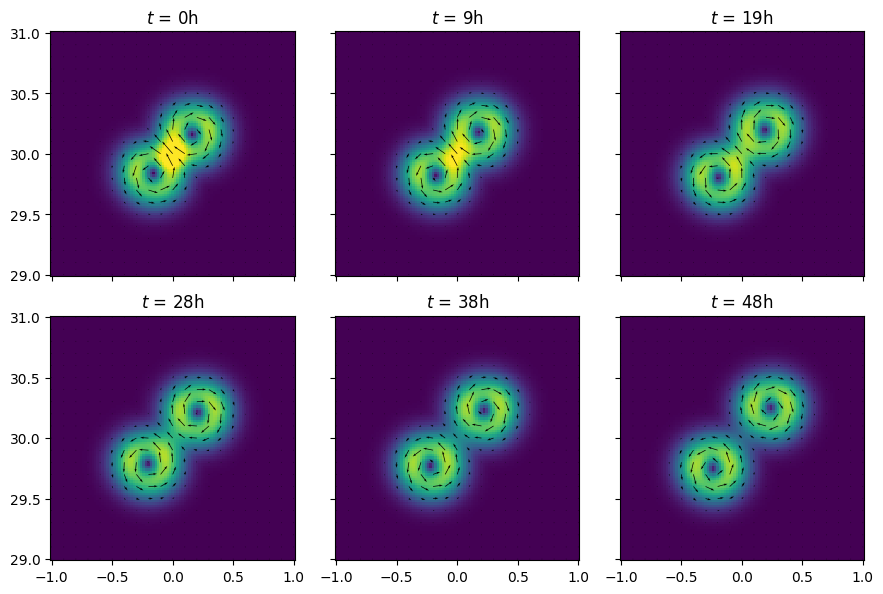

In [4]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9, 6))
axes = axes.flatten()

for ax_i, uv_i in zip(range(axes.size), jnp.linspace(0, nt - 1, axes.size).astype(int)):
    ax = axes[ax_i]
    
    im = ax.pcolormesh(
        lon, lat,
        jnp.sqrt(u[uv_i]**2 + v[uv_i]**2), 
        vmax=2.75, vmin=0,
        cmap="viridis"
    )
    ax.quiver(
        lon[::5], lat[::5], 
        u[uv_i][::5, ::5], v[uv_i][::5, ::5],
        scale=50
    )
    ax.set_title(f"$t$ = {ts[uv_i] / 60 / 60:.0f}h")

    ax.set_aspect("equal")

    if ax_i < 3:
        ax.tick_params(bottom=True, labelbottom=False, top=False, labeltop=False)
    else:
        ax.tick_params(bottom=True, labelbottom=True, top=False, labeltop=False)

fig.tight_layout()

### Simulating a single trajectory

Let's start with the simplest use-case: advecting a single particle inside a given velocity field $\mathbf{u}$.

In order to interpolate this velocity field during the simulation of the trajectory we define a [`pastax.grid.Dataset`][] (a `xarray.Dataset`-likish object compatible with JAX just-in-time compilation mechanism).

In [5]:
from pastax.grid import Dataset


two_eddies_ds = Dataset.from_arrays(
    variables={"u": u, "v": v},  # the fields
    time=ts, latitude=lat, longitude=lon,  # the coordinates
)

The initial position of our particle is 30° latitude and 0° longitude, right in between the two eddies.
We use [`pastax.trajectory.Location`][] structure to represent positions.

In [6]:
from pastax.trajectory import Location


x0 = Location([30, 0])
ts_sim = ts[1:-1]

Finally, we will advect this particle using the [`pastax.simulator.IdentitySSC`][] simulator.

In [7]:
from pastax.simulator import IdentitySSC


dt0 = jnp.asarray(15*60)  # integration timestep: 15 minutes in seconds

ssc_sim = IdentitySSC()
traj = ssc_sim(args=two_eddies_ds, x0=x0, ts=ts_sim, dt0=dt0)

The simulator outputs a [`pastax.trajectory.Trajectory`][] object.
We can plot it using its [`pastax.trajectory.Trajectory.plot`][] method.

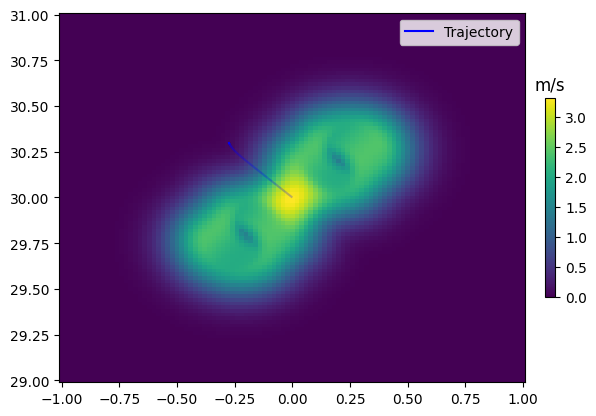

In [8]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("m/s")

# add the trajectory
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

Because the particle is released between the eddies, its trajectory does not represent neither of the eddies, which might not seem very realistic.

To remedy this, we can try to generate a stochastic ensemble of trajectories.

### Simulating a trajectory ensemble

Instead of a single trajectory, we will now generate an ensemble of 100 trajectories by sampling solutions from a Stochastic Differential Equation with Smagorinsky diffusion using the [`pastax.simulator.SmagorinskyDiffusion`][] simulator.

In [9]:
from pastax.simulator import SmagorinskyDiffusion


n_samples = jnp.asarray(100)

smag_sim = SmagorinskyDiffusion.from_param(cs=1e-1)
traj_ens = smag_sim(args=two_eddies_ds, x0=x0, ts=ts_sim, dt0=dt0, n_samples=n_samples)

This time, the simulator returns a [`pastax.trajectory.TrajectoryEnsemble`][].
Again, we can plot the trajectories using the [`pastax.trajectory.TrajectoryEnsemble.plot`][] method.

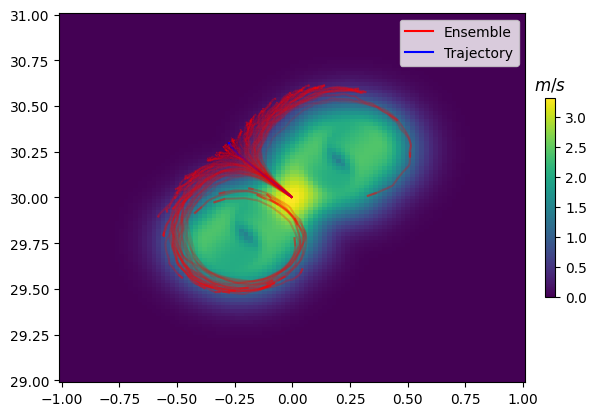

In [10]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the ensemble
ax = traj_ens.plot(ax, label="Ensemble", color="red")

# add the trajectory on top
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

We see that the ensemble much better represent the presence of the two eddies.

## Learning simulators parametrization

Using [`JAX`](https://jax.readthedocs.io/) we have the ability to write fully differentiable simulators and to learn their parametrization (even for a large number of parameters, such as a neural network).

To demonstrate how we can do this, we will focus on the very simple scenario of a constant (in space and time) velocity field $\mathbf{u}$ and two deterministic simulators that use only a velocity field to simulate a trajectory.

One simulator knows $\mathbf{u}$, and we will use its simulated trajectory as reference to fit the parameters of the other one.
That second simulator uses as input a modified version of the velocity field: $\widehat{\mathbf{u}} = (\mathbf{u} - b) / a$, and apply the linear transformation $x \mapsto \beta_0 + x \beta_1$ to $\widehat{\mathbf{u}}$.
Starting from randomly generated $\beta_0$ and $\beta_1$, we will retrieve their expected values $b$ and $a$, respectively.

In [11]:
ref_cst_u = jnp.full((nt, ny, nx), 0.5)
ref_cst_v = jnp.full((nt, ny, nx), 0.25)

ref_cst_ds = Dataset.from_arrays(
    variables={"u": ref_cst_u, "v": ref_cst_v},
    time=ts, latitude=lat, longitude=lon,
)

In [12]:
a = 2
b = 0.1

trans_cst_u = (ref_cst_u - b) / a
trans_cst_v = (ref_cst_v - b) / a

trans_cst_ds = Dataset.from_arrays(
    variables={"u": trans_cst_u, "v": trans_cst_v},
    time=ts, latitude=lat, longitude=lon
)

We use a [`pastax.simulator.IdentitySSC`][] as the simulator using the true velocity field $\mathbf{u}$, and a [`pastax.simulator.LinearSSC`][], whose `intercept` and `slope` parameters can be optimized, as the simulator using the modified velocity field $\widehat{\mathbf{u}}$.

In [13]:
import jax.random as jrd

from pastax.simulator import LinearSSC


ref_sim = IdentitySSC()

keys = jrd.split(jrd.key(0), 2)
intercept = jrd.uniform(keys[0], 1, dtype=float, minval=-1, maxval=1)
slope = jrd.uniform(keys[1], 1, dtype=float, minval=-1, maxval=1)
trans_sim = LinearSSC.from_param(intercept=intercept, slope=slope)

print(f"Initial parameters: (intercept={intercept.item()}, slope={slope.item()})")

Initial parameters: (intercept=-0.03947928024531988, slope=0.15310165206863147)


Let's see how their simulated trajectories compare...

In [14]:
ref_traj = ref_sim(args=ref_cst_ds, x0=x0, ts=ts_sim, dt0=dt0)
est_traj = trans_sim(args=trans_cst_ds, x0=x0, ts=ts_sim, dt0=dt0)

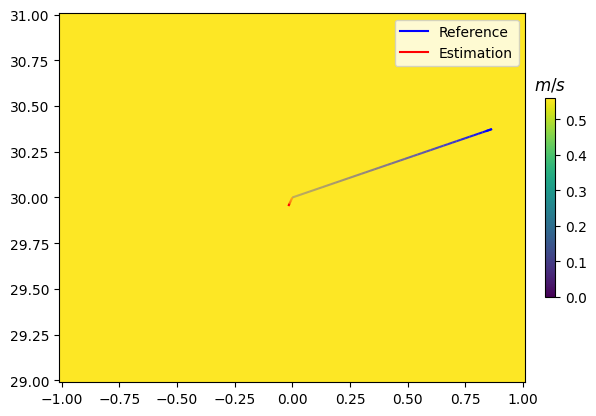

In [15]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((ref_cst_u[0]**2 + ref_cst_v[0]**2)), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the reference
ax = ref_traj.plot(ax, label="Reference", color="blue")

# add the estimation
ax = est_traj.plot(ax, label="Estimation", color="red")
ax.legend()

plt.show()

As expected given the sampled values of $\beta_0$ and $\beta_1$, the estimate is quite far from the reference.

To improve this estimation by adjusting the parameters $\beta_0$ and $\beta_1$ using automatic differentiation, we essentially need to define an objective function (or loss) to minimize, and a minimizer.

There is plenty of options for the choice objective function, including:

- the Liu Index,
- the Separation distance (distance on Earth in meters),
- the Euclidean distance (distance in degrees),
- ...

that we can evaluate either at the final position of the particle or along its full trajectory.

In this case, we use the sum of the euclidean distances calculated every hour between the reference and the estimated trajectory, that we square to ease minimization.

In [16]:
import equinox as eqx


@eqx.filter_value_and_grad
def objective_fn(_sim):
    _traj = _sim(args=trans_cst_ds, x0=x0, ts=ts_sim, dt0=dt0)
    return (ref_traj.euclidean_distance(_traj).sum()**2 / 2).value

!!! note
    We use [`Equinox`](https://docs.kidger.site/equinox/) to represent and manipulate Python objects as PyTrees.

We can verify it is possible to evaluate the loss and its gradients.

In [17]:
loss, grads = objective_fn(trans_sim)

print(
    f"Initial loss: {loss} and "
    f"gradients: (intercept={grads.rhs.intercept.item()}, slope={grads.rhs.slope.item()})"
)

Initial loss: 259.2976618652764 and gradients: (intercept=-1172.4252167008515, slope=-191.9264376045031)


Thanks to [`Optax`](https://optax.readthedocs.io/), we have access to a large variety of optimizers.
In this example we will use the classical Adam optimizer.

In [18]:
import optax


learning_rate = 1e-1

optim = optax.adam(learning_rate)
opt_state = optim.init(trans_sim)

Because we rely on [`Equinox`](https://docs.kidger.site/equinox/), it is also straightforward to apply gradient-based updates to the simulator parameters (as it is a PyTree).

In [19]:
@eqx.filter_jit
def make_step(_sim, _opt_state):
    _loss, grads = objective_fn(_sim)
    updates, _opt_state = optim.update(grads, _opt_state)
    _sim = eqx.apply_updates(_sim, updates)
    return _loss, _sim, _opt_state

Finally, we perform the optimization over 200 update steps:

In [20]:
n_steps = 200
print_every = 20

for step in range(n_steps):
    loss, trans_sim, opt_state = make_step(trans_sim, opt_state)
    if (step % print_every) == 0 or step == n_steps - 1:
        print(f"Step: {step}, Loss: {loss.item()}")

Step: 0, Loss: 259.2976618652764
Step: 20, Loss: 24.017840962552373
Step: 40, Loss: 6.190829084981727
Step: 60, Loss: 1.7930803102977988
Step: 80, Loss: 0.42655486026113854
Step: 100, Loss: 0.08808017716898713
Step: 120, Loss: 0.010986454476463165
Step: 140, Loss: 0.0007682532405133117
Step: 160, Loss: 1.3627651436636214e-05
Step: 180, Loss: 6.699587574700361e-06
Step: 199, Loss: 2.444729937215066e-06


After optimization, the fitted parameters of the calibrated simulator correspond to their expected values:

In [25]:
print(f"Final parameters: (intercept={trans_sim.rhs.intercept.item()}, slope={trans_sim.rhs.slope.item()})")

Final parameters: (intercept=0.09991617278188675, slope=2.0006293324761972)


Therefore, we should now find a very good agreement between the two trajectories.

In [22]:
est_traj = trans_sim(args=trans_cst_ds, x0=x0, ts=ts_sim, dt0=dt0)

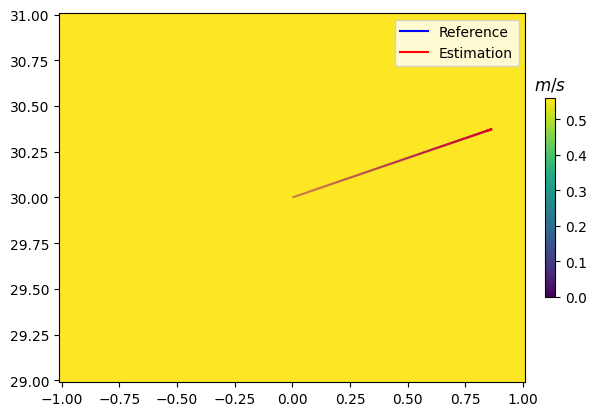

In [23]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((ref_cst_u[0]**2 + ref_cst_v[0]**2)), 
    cmap="viridis", vmin=0
)
clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)

clb.ax.set_title("$m/s$")

# add the reference
ax = ref_traj.plot(ax, label="Reference", color="blue")

# add the estimation
ax = est_traj.plot(ax, label="Estimation", color="red")
ax.legend()

plt.show()

And indeed, in this toy use-case, we were able to perfectly simulate the reference trajectory.